In [23]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

# Load and preparation of data

In [12]:
challenges_df = pd.read_csv('challenge_data.csv', encoding= 'latin-1')

In [13]:
challenge_data_df =challenges_df.drop([ 'uuid', 'created_at', 'updated_at', 'Entity.LegalAddress.Region', 'Entity.HeadquartersAddress.Region'], axis = 1)
null_columns = challenge_data_df.columns[challenge_data_df.isnull().any()]
challenge_data_df[null_columns].isnull().sum()

challengeable_type                       203
subject_key                              203
subject_type                             203
subject_owner                            203
subject_source                           203
subject_source_date                      203
comment                                  203
Entity.LegalName                         203
Entity.LegalAddress.Country              203
Entity.LegalAddress.PostalCode           234
Entity.HeadquartersAddress.Country       203
Entity.HeadquartersAddress.PostalCode    239
Entity.LegalJurisdiction                 203
Entity.EntityStatus                      203
Registration.RegistrationStatus          203
Registration.ValidationSources           203
dtype: int64

In [14]:
#dropping null or missing values
challenge_data_df = challenge_data_df.dropna(how='any')
len(challenge_data_df)

1286

# Challenges data analysis

#### Challenge types
--------------------------------
As the initial step for the analysis of challenges data, the "challenge type" is manually decided based on the key words of the comment column.

The challenge type/ comment_type is categorized as follows,

* comments which contains "address" or "Message 548" are as "Address related"	
* comments which contains "LEI" are as "LEI related"
* comments which contains "name" are as "Name related"
* comments which contains "uid" or "id" as "UID/ID related"
* All the comments are as "Other"

In [15]:
challenge_data_df['comment_type'] = np.where((challenge_data_df['comment'].str.contains("address|Message 548", case = False) ), 'Address related', 'Other')
challenge_data_df['comment_type'] = np.where((challenge_data_df['comment'].str.contains("LEI") ), 'LEI related', challenge_data_df.comment_type)
challenge_data_df['comment_type'] = np.where((challenge_data_df['comment'].str.contains("name", case = False) ), 'Name related', challenge_data_df.comment_type)
challenge_data_df['comment_type'] = np.where((challenge_data_df['comment'].str.contains("uid|id", case = False) ), 'UID/ID related', challenge_data_df.comment_type)
challenge_data_df[['comment_type','comment']].head(5)

,comment_type,comment
0,Address related,Please remove the additional address line as i...
1,Address related,This challenge is raised as part of the accura...
2,Address related,Address line is included by mistake
3,Other,RELX GROUP PLC Annual Report 2018 (https://www...
4,Name related,Both names and Country is same- they are dupli...


## Distribution of each challenge type categorized above

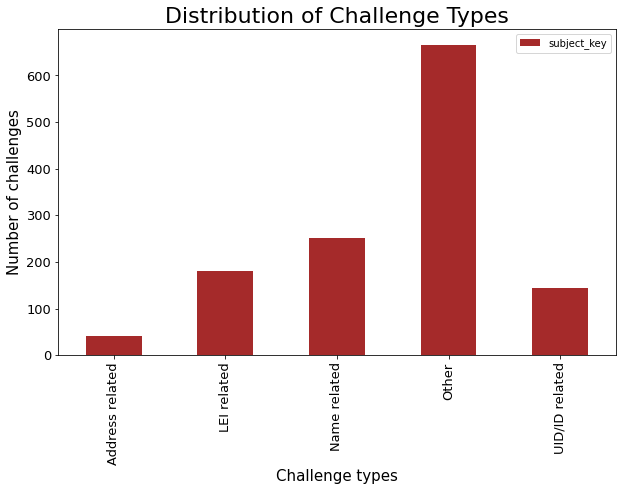

In [17]:
# Challenge type counts
types_df = (challenge_data_df.groupby(['comment_type'])['subject_key'].count()).to_frame().reset_index()

# Plot the distribution
ax = types_df.plot(kind='bar', figsize=(10,6), color="Brown", fontsize=13, x= 'comment_type' );
ax.set_alpha(0.8)
ax.set_title("Distribution of Challenge Types", fontsize=22)
ax.set_xlabel("Challenge types", fontsize=15);
ax.set_ylabel("Number of challenges", fontsize=15);
plt.show()

NOTE:

Address challenges are the least challenges recorded according to the dataset.

It's only 42 Address realted challenges in the data set.

Name related challenges are considerably higher than the other challanges.

-------------------

## Challenges per subject owner

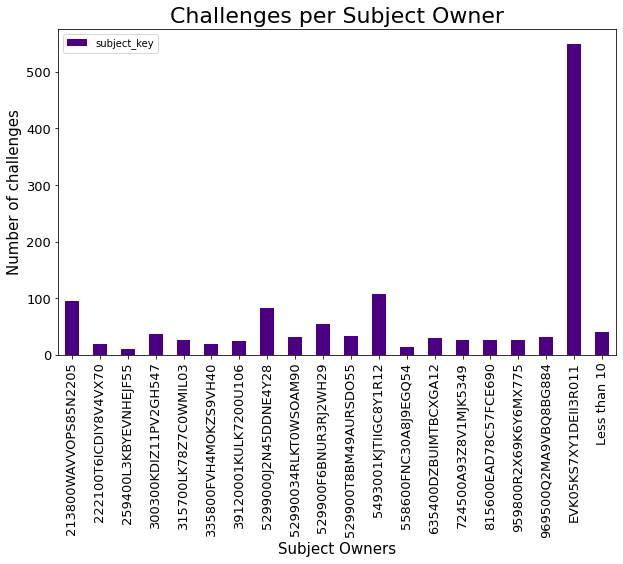

In [20]:
# Count of LEIs for each subject owner
owner_df =(challenge_data_df.groupby(['subject_owner'])['subject_key'].count()).to_frame().reset_index()
owner_df.columns
owner_df['subject_owner_new'] = np.where((owner_df['subject_key']<= 10 ), 'Less than 10',owner_df.subject_owner)
owner_df[['subject_owner_new','subject_key']]
owner_df = owner_df.groupby(['subject_owner_new'], as_index=False).agg({'subject_key':sum})

# Plot the destribution
ax1 = owner_df.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=13, x= 'subject_owner_new' );
ax1.set_alpha(0.8)
ax1.set_title("Challenges per Subject Owner", fontsize=22)
ax1.set_xlabel("Subject Owners", fontsize=15);
ax1.set_ylabel("Number of challenges", fontsize=15);
plt.show()

NOTE:

"EVK05KS7XY1DEII3R011" subject owner has the highest number of challenges which is 549 challenges.

All the other subject owners( LOU) have average of 30 challenges recorded under.

-------------------

## Challenges per LEI

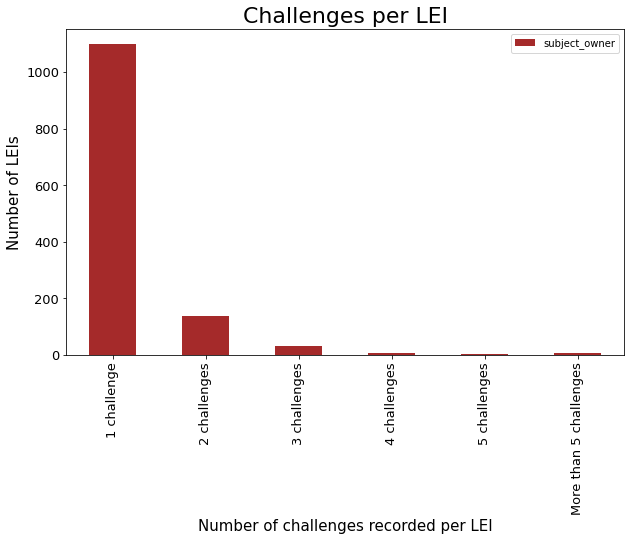

In [22]:
# categorizing the LEIs based on the number of challenges raised
leis_df =(challenge_data_df.groupby(['subject_key'])['subject_owner'].count()).to_frame().reset_index()
leis_df['subject_key_new'] = np.where((leis_df['subject_owner']== 1 ), '1 challenge',leis_df.subject_key)
leis_df['subject_key_new'] = np.where((leis_df['subject_owner']== 2 ), '2 challenges',leis_df.subject_key_new)
leis_df['subject_key_new'] = np.where((leis_df['subject_owner']== 3 ), '3 challenges',leis_df.subject_key_new)
leis_df['subject_key_new'] = np.where((leis_df['subject_owner']== 4 ), '4 challenges',leis_df.subject_key_new)
leis_df['subject_key_new'] = np.where((leis_df['subject_owner']== 5 ), '5 challenges',leis_df.subject_key_new)
leis_df['subject_key_new'] = np.where((leis_df['subject_owner']>=6 ), 'More than 5 challenges',leis_df.subject_key_new)
leis_df = leis_df.groupby(['subject_key_new'], as_index=False).agg({'subject_owner':sum})

#Plot the destribution
ax2 = leis_df.plot(kind='bar', figsize=(10,6), color="Brown", fontsize=13, x= 'subject_key_new', y= 'subject_owner', sort_columns = True);
ax2.set_alpha(0.9)
ax2.set_title("Challenges per LEI", fontsize=22)
ax2.set_xlabel("Number of challenges recorded per LEI", fontsize=15);
ax2.set_ylabel("Number of LEIs", fontsize=15);
plt.show()

NOTE:

Most of the LEIs are challenged only one time.

But considerable number of LEIs are challenged more than one time.

---------------------------------

# Unsupervised Text Clustering for the comments

------------------------

In this method, it is used the KMeans clustering method to cluster the challenge data according to the comments after remidiation of the challenges.

For the unsupervised k-means clustering method, "comment" section for each challenge has taken to cluster the data. Because according to the comments it describe thr nature of the challenges.

### Extract the features from the comment data

In [24]:
comments = challenge_data_df['comment']
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comments)

### Identiying optimal number of clusters using the eblow method

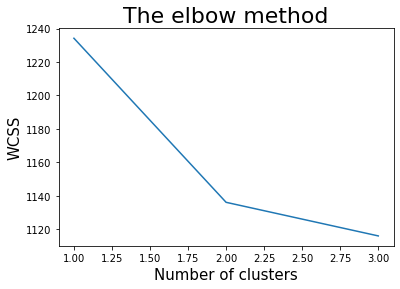

In [26]:
wcss = []
for i in range(1,4):
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state= 42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,4),wcss)
plt.title("The elbow method", fontsize=22)
plt.xlabel("Number of clusters", fontsize=15);
plt.ylabel("WCSS", fontsize=15);
plt.show()

NOTE: Above shows the elbow method for k means algorithm. Thus, by looking at the graph, the optimal number of clusters is found to be 2.

## KMeans Clustering for the comment data

---
NOTE: 
The clusters are plotted using the Principle Component Analysis (PCA) with ‘X’ indicating the cluster centers.

Following function cluster the data upto 7 clusters

In [60]:
def comment_clustering(categories):
    #Implementing k-means clustering algorithm in the vectorized document
    true_k = categories
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
    model.fit(X)

    #Determining centroids and features
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()

    #make the predictions
    Y = vectorizer.transform(comments)
    prediction = model.predict(Y)

    #Plotting the clusters
    pca = TruncatedSVD(n_components= 2).fit(X)
    coords = pca.transform(X)
    labels = prediction
    label_colors = ["#2AB0E9","#FC6514","#CCCCCC","#D2CA0D","#2BAF74","#D7665E","#A3DB05"]
    colors = [label_colors[i] for i in labels]
    plt.scatter(coords[:,0], coords[:,1], c=colors)
    centroids = model.cluster_centers_
    centroid_coords = pca.transform(centroids)
    plt.scatter(centroid_coords[:, 0],centroid_coords[:, 1], marker = 'X', s=200, linewidths=2, c='#444d61')
    plt.title("The PCA plot for the clusters")
    plt.show

    #Top words per cluster
    print("Top terms per cluster:")
    cols = []
    for i in range(0,true_k): 
        columns = "Cluster %d" % i
        cols.append(columns)

    df = pd.DataFrame(columns=cols)
    for i in range(0,true_k): 
        c= "Cluster %d" % i
        arr = []
        for ind in order_centroids[i, :10]:
            a =' %s' % terms[ind]
            arr.append(a)
        df[c] = arr
    print(df)

### Clustering the data based on the comment for the optimal number of clusters

Comment clustering for the optimal number of clusters
Top terms per cluster:
     Cluster 0    Cluster 1
0          lei         dear
1    duplicate          lou
2       parent         team
3      company          lei
4      address         gmei
5     ultimate        bonds
6        https      belongs
7        hello           bg
8   duplicates       bezler
9       review   betashares


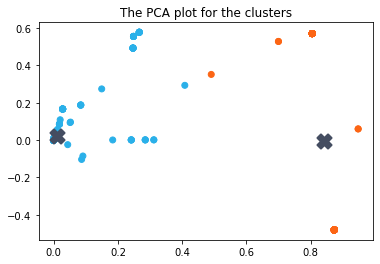

In [61]:
comment_clustering(2)

### Clustering the data based on the comment for 5 clusters as we manually categorized the comments

Top terms per cluster:
     Cluster 0      Cluster 1              Cluster 2  Cluster 3    Cluster 4
0          lou        address                 parent       team          lei
1         dear      duplicate               ultimate       dear        https
2         team         review                    lei      hello    duplicate
3           æµ          based                company         hi          www
4          big         kindly              reference        lei       source
5          bhw          gleif                  owner       gmei   duplicates
6           bg         portal   2w8n8uu78pmdqkzenc08   business       entity
7       bezler         number                retired       data           id
8   betashares     duplicates                managed     entity      company
9         beta   registration                   used    bermuda        hello


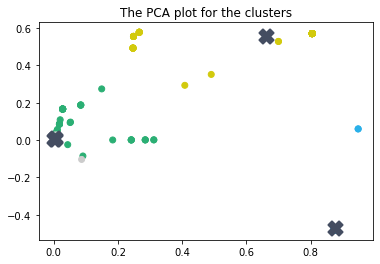

In [62]:
comment_clustering(5)